In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('classification.csv')
df.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,college degree,17,12,176,9.3,11.359392,5.008608,1
1,27,no high school,10,6,31,17.3,1.362202,4.000798,0
2,40,no high school,15,14,55,5.5,0.856075,2.168925,0
3,41,no high school,15,14,120,2.9,2.658720,0.821280,0
4,24,high school,2,0,28,17.3,1.787436,3.056564,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       700 non-null    int64  
 1   ed        700 non-null    object 
 2   employ    700 non-null    int64  
 3   address   700 non-null    int64  
 4   income    700 non-null    int64  
 5   debtinc   700 non-null    float64
 6   creddebt  700 non-null    float64
 7   othdebt   700 non-null    float64
 8   default   700 non-null    int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 49.3+ KB


In [4]:
df.default.value_counts()

0    517
1    183
Name: default, dtype: int64

In [5]:
df.groupby('default').mean()

,age,employ,address,income,debtinc,creddebt,othdebt
default,,,,,,,
0,35.514507,9.508704,8.945841,47.154739,8.679304,1.245493,2.773409
1,33.010929,5.224044,6.393443,41.213115,14.727869,2.423865,3.862807


As we can see the average age of people who got credit is lower than of those who did not. However (and it is strange) people who did not get credit have higher income in general.

In [ ]:
df.groupby('ed').mean()

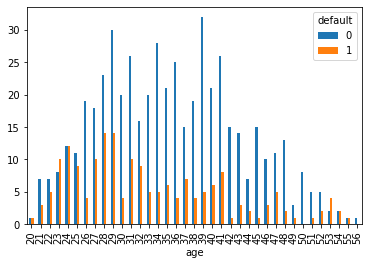

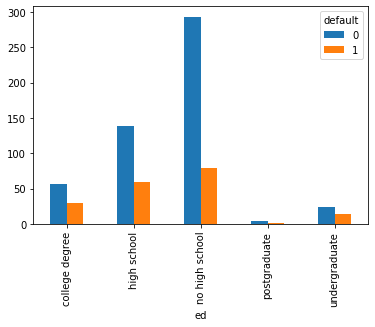

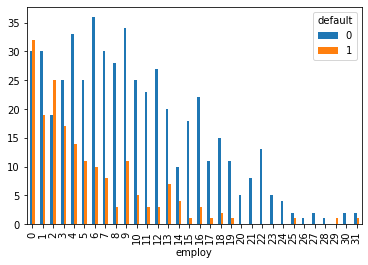

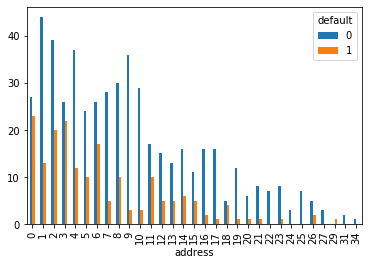

In [6]:
for i in list(df.columns[:4]):
    pd.crosstab(df[i],df.default).plot(kind='bar')
    plt.show()

In [7]:
#Getting dummies for categorical feature 'ed'
print(df.ed.unique())
ed = pd.get_dummies(df.ed,prefix='ed')
df = df.join(ed)
df.drop('ed',axis=1,inplace=True)
print(df.head())

['college degree' 'no high school' 'high school' 'undergraduate'
 'postgraduate']
   age  employ  address  income  debtinc   creddebt   othdebt  default  \
0   41      17       12     176      9.3  11.359392  5.008608        1   
1   27      10        6      31     17.3   1.362202  4.000798        0   
2   40      15       14      55      5.5   0.856075  2.168925        0   
3   41      15       14     120      2.9   2.658720  0.821280        0   
4   24       2        0      28     17.3   1.787436  3.056564        1   

   ed_college degree  ed_high school  ed_no high school  ed_postgraduate  \
0                  1               0                  0                0   
1                  0               0                  1                0   
2                  0               0                  1                0   
3                  0               0                  1                0   
4                  0               1                  0                0   

   ed_undergradu

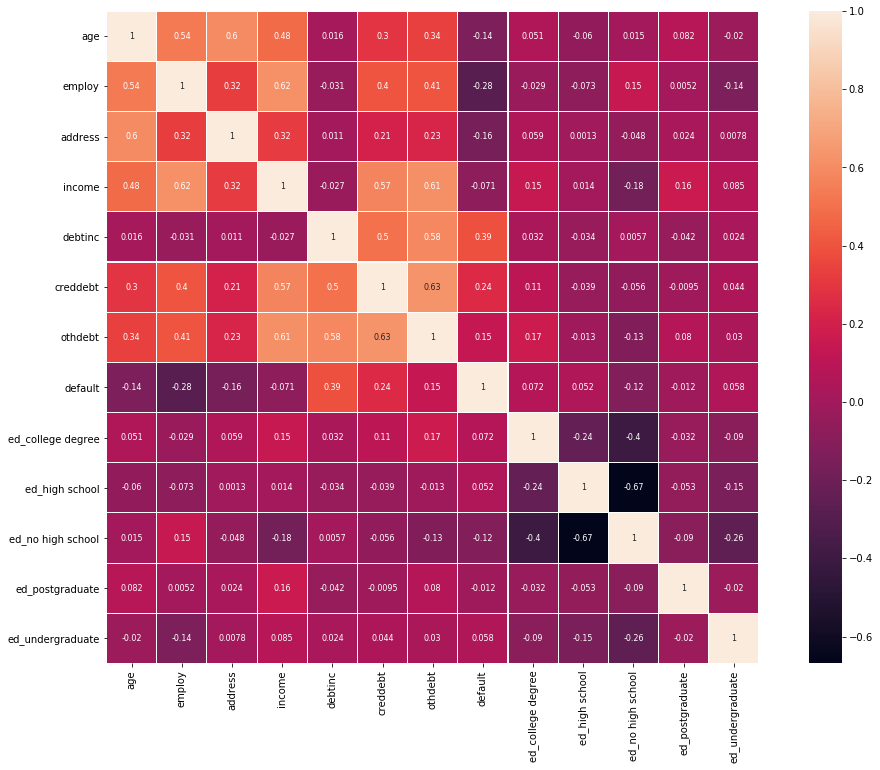

In [9]:
f,ax=plt.subplots(figsize=(18,12))
sns.heatmap(df.corr(),square=True, linewidths=0.1, annot=True, annot_kws={"size": 8})

From the correlation matrix we can see that feature 'employ' has high correlation with 'age','income','address'. 
'Creddebt' has high correlation with 'income','othdebt', 'debtinc'.
However, there are no features which have very high correlation with each other thus we will consider that there is not multicolleniarity within features and that they all should be used in our model.

In [10]:
df.describe()

,age,employ,address,income,debtinc,creddebt,othdebt,default,ed_college degree,ed_high school,ed_no high school,ed_postgraduate,ed_undergraduate
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,34.860000,8.388571,8.278571,45.601429,10.260571,1.553553,3.058209,0.261429,0.124286,0.282857,0.531429,0.007143,0.054286
std,7.997342,6.658039,6.824877,36.814226,6.827234,2.117197,3.287555,0.439727,0.330143,0.450710,0.499368,0.084273,0.226743
min,20.000000,0.000000,0.000000,14.000000,0.400000,0.011696,0.045584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,3.000000,3.000000,24.000000,5.000000,0.369059,1.044178,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,7.000000,7.000000,34.000000,8.600000,0.854869,1.987567,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,40.000000,12.000000,12.000000,55.000000,14.125000,1.901955,3.923065,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,56.000000,31.000000,34.000000,446.000000,41.300000,20.561310,27.033600,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From the above metrics we can notice that the maximum value of all the features are quite different from the mean of those features and that the distribution of features seemed to be right skewed.
Let's check the distribution of those features.

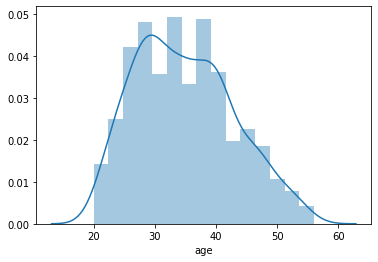

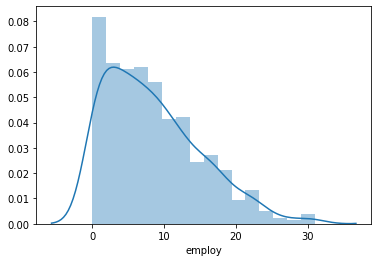

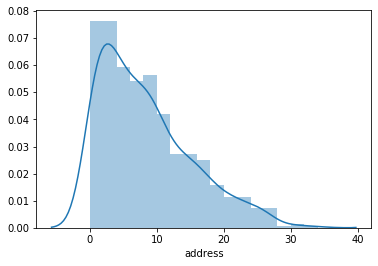

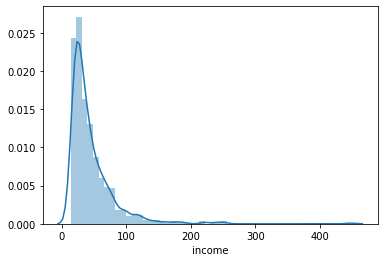

In [13]:
for i in list(df.columns[:4]):
    sns.distplot(df[i])
    plt.show()

So we see that only the 'age' feature has close to normal distribution. We could remove the highest outlier from the 'income' feature.

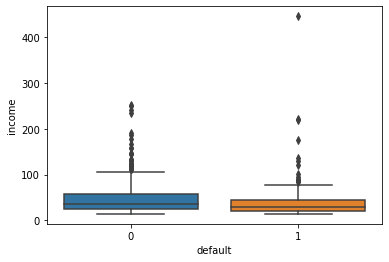

In [12]:
sns.boxplot(x=df['default'],y=df['income'])

In [11]:
df.sort_values('income',ascending=False).head()
#df.drop(444,axis=0,inplace=True)

,age,employ,address,income,debtinc,creddebt,othdebt,default,ed_college degree,ed_high school,ed_no high school,ed_postgraduate,ed_undergraduate
444,43,18,14,446,6.5,16.031470,12.958530,1,0,0,0,0,1
691,47,31,8,253,7.2,9.308376,8.907624,0,0,0,1,0,0
528,51,31,14,249,7.8,4.272840,15.149160,0,0,1,0,0,0
450,43,25,16,242,2.6,1.635920,4.656080,0,0,0,1,0,0
557,52,13,17,234,7.7,7.387380,10.630620,0,0,0,0,0,1


However, we will keep it and scale that column with other columns.

In [15]:
mms = MinMaxScaler()
clf = LogisticRegression()

In [27]:
y = df.default
X = df.drop('default',axis=1)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101)
X_train_s = mms.fit_transform(X_train)
X_test_s = mms.transform(X_test)

In [32]:
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0]
penalty = ['l1', 'l2']
param_grid = dict(C=c_values, penalty=penalty)
kfold = KFold(n_splits=5, random_state=101)
grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(X_train_s, y_train)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))

Best: 0.8071428571428572 using {'C': 6.5, 'penalty': 'l2'}


In [33]:
clf = LogisticRegression(C=6.5,penalty='l2')
clf.fit(X_train_s,y_train,)
y_pred = clf.predict(X_test_s)
y_train_pred = clf.predict(X_train_s)

#we will first evaluate the metrics using sklearn and then compare the results with metrics we obtain from our function
print('Test_accuracy:',accuracy_score(y_test,y_pred))
print('Train_accuracy:',accuracy_score(y_train,y_train_pred))
print('Confusion matrix and classification report for test set:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test_accuracy: 0.8071428571428572
Train_accuracy: 0.8160714285714286
Confusion matrix and classification report for test set:
[[96  4]
 [23 17]]
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       100
           1       0.81      0.42      0.56        40

    accuracy                           0.81       140
   macro avg       0.81      0.69      0.72       140
weighted avg       0.81      0.81      0.79       140



**Function for metrics estimation**

In [34]:
def compute_params(y_test,y_pred):
    TP = sum((y_test==1)&(y_pred==1))
    TN = sum((y_test==0)&(y_pred==0))
    FP = sum((y_test==0)&(y_pred==1))
    FN = sum((y_test==1)&(y_pred==0))
    Accuracy = ((TP+TN)*100)/float(TP+TN+FN+FP)
    Precision = TP*100 / float(FP + TP)
    Recall = TP*100 / float(TP+FN)
    f1_score = 2*Precision*Recall / (Precision + Recall)
    Sensitivity = TP*100/float(TP+FN)
    Specificity = TN*100/float(TN+FP)
    confusion_matrix = np.array([TP,FP,FN,TN]).reshape(2,2)
    return TP, TN, FP, FN, Accuracy, Precision, Recall, f1_score, Sensitivity, Specificity, confusion_matrix

*Test Set*

In [35]:
TP, TN, FP, FN, Accuracy, Precision, Recall, f1_score, Sensitivity, Specificity, confusion_matrix = compute_params(y_test,y_pred)

In [36]:
print(confusion_matrix)

[[17  4]
 [23 96]]


In [37]:
print(Accuracy)

80.71428571428571


*Train set*

In [38]:
TP, TN, FP, FN, Accuracy, Precision, Recall, f1_score, Sensitivity, Specificity, confusion_matrix = compute_params(y_train,y_train_pred)

In [39]:
print(confusion_matrix)

[[ 65  25]
 [ 78 392]]


In [40]:
print(Accuracy)

81.60714285714286


**Below is the example of how we could make crossvalidation without cross_val and gridsearch**

In [50]:
y = df.default
X = df.drop('default',axis=1)

In [55]:
def model_building(X,y,n,clf):
    kf = KFold(n_splits=n,shuffle=False,random_state=101)
    test_accuracy = []
    train_accuracy = []
    precision = []
    recall = []
    f1 = []
    mms = MinMaxScaler()
    for train_id, test_id in kf.split(X):
        X_train, X_test = X.iloc[train_id], X.iloc[test_id]
        y_train, y_test = y.iloc[train_id], y.iloc[test_id]
        X_train_s = mms.fit_transform(X_train)
        X_test_s = mms.transform(X_test)
        model = clf.fit(X_train_s,y_train)
        y_pred = model.predict(X_test_s)
        y_pred_train = model.predict(X_train_s)
        test_accuracy.append(clf.score(X_test_s,y_test))
        train_accuracy.append(clf.score(X_train_s,y_train))
        precision.append(precision_score(y_test,y_pred))
        recall.append(recall_score(y_test,y_pred))
    scores = pd.DataFrame({'test_accuracy':test_accuracy,'train_accuracy':train_accuracy,'precision':precision,'recall':recall})
    print(scores)
    print('Train_accuracy_mean:',np.array(train_accuracy).mean(),'Test_acuracy_mean:',np.array(test_accuracy).mean())
    return y_test, y_pred, y_train, y_pred_train

In [56]:
y_test, y_pred, y_train, y_pred_train = model_building(X,y,5,LogisticRegression())

   test_accuracy  train_accuracy  precision    recall
0       0.785714        0.796429   0.550000  0.343750
1       0.764286        0.791071   0.500000  0.151515
2       0.821429        0.796429   0.866667  0.361111
3       0.771429        0.801786   0.823529  0.325581
4       0.807143        0.787500   0.875000  0.358974
Train_accuracy_mean: 0.7946428571428571 Test_acuracy_mean: 0.7899999999999998


In [57]:
TP, TN, FP, FN, Accuracy, Precision, Recall, f1_score, Sensitivity, Specificity, confusion_matrix = compute_params(y_test,y_pred)

In [58]:
Accuracy

80.71428571428571

In [60]:
TP, TN, FP, FN, Accuracy, Precision, Recall, f1_score, Sensitivity, Specificity, confusion_matrix = compute_params(y_train,y_pred_train)

In [61]:
Accuracy

78.75